# Extension Analyze

This notebook does a few things:
1. It visualizes the slope of employment rate compared to covid spread rate
    - At a County level
    - At a State level
2. It does a t-test to analyze if there is a signficant impact between employment rate and covid spread
3. It calculates how much the county employment rate slope impacts the state employment rate
    - It does this by sitting a simple linear regression model with employment rate as the X, and covid spread as the Y.

In [6]:
#### IMPORTS ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

> Below are helpful reusable functions for further extension. They aid in the analysis in this notebook but can be customized further for your own county analysis.

In [7]:
### HELPFUL FUNCTIONS ###
def calculate_proportion_explained(county_diff, state_diff):
    '''
    This function calculates the proportion of variance 
    explained from fitting a linear model on the county and state slopes.
    '''
    x, y = np.array(county_diff).reshape(-1, 1), np.array(state_diff).reshape(-1, 1)

    model = LinearRegression().fit(x, y)
    prediction = model.predict(x)
    residuals = (y - prediction)
    
    total_variance = np.var(y)
    residual_variance = np.var(residuals)
    residual_explained = total_variance - residual_variance
    proportion_explained = residual_explained / total_variance
    return proportion_explained

def calculate_correlation_coefficient(slope1, slope2):
    '''
    This is a basic function that uses numpy to calculate the
    pearson correlation coefficient between two slopes
    to calculaet if they are signficant (using some form of hypothesis testing)
    '''
    r, _ = pearsonr(slope1, slope2)
    return r

def calculate_rate_of_change(df, col_name='confirmed_cases', period=1):
    '''Helper function to calculate rate of change in a variable such as covid/employment_rate/income/etc'''
    return df[col_name] - df.shift(periods=period)[col_name]

def format_and_index_date(df, date_col):
    '''
    A lot of visualizations + analysis tasks need date as an index for plotting and merging 
    reasons. For this reason, this function sets a `date_non_index` which can be used to clean
    the data but also adds date as an index. It also will set any datetime datatypes and extract
    year and month for analysis.
    '''
    if 'date' in df.columns or isinstance(df.index, pd.core.indexes.datetimes.DatetimeIndex):
        # just set non_index & get year and month
        df['date_non_index'] = df.index
        df['date_non_index'] = pd.to_datetime(df['date_non_index'])
        df['year'] = df['date_non_index'].dt.year
        df['month'] = df['date_non_index'].dt.month
        return df
    
    df['date'] = df.apply(lambda x: str(x.period) + '-' + str(x.year), axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['date_non_index'] = df.index
    return df

def subset_data_to_range(df, start_date, end_date):
    '''Helper function to subset the data to a specific date range.'''
    return df[(df.index >= start_date) & (df.index <= end_date)]

def visualize_timeseries(df, title, cols, label_names, colors, figsize=(14,10)):
    '''Visualizes a time series given the 
    1. dataframe - data
    2. title - plot title
    3. cols - column names to plot
    4. label_names - names to assign these columns in legend
    5. colors - colors to assign these lines
    6. Optional figsize - figure size to increase or decrease plot
    '''
    plt.clf() # clear any existing plots
    fig, ax = plt.subplots(figsize=figsize)
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    years_fmt = mdates.DateFormatter('%Y-%m')
    
    for idx, col in enumerate(cols):
        sns.lineplot(data=df[col], ax=ax, color=colors[idx], label=label_names[idx])

    ax.legend()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Rate of change')
    plt.xticks(rotation = 'vertical')
    plt.show()

## Retrieve the data
> First we retrieve the produced data from previous steps including the metro/state unemployment data, and nevada covid data. These will use the date formatting functionality above to merge the two datasets together.

In [8]:
unemployment_df = pd.read_csv('data/produced_data/combined_metro_state_data.csv', parse_dates = True)
unemployment_df = format_and_index_date(unemployment_df, 'date')
unemployment_df = subset_data_to_range(unemployment_df, '2020-02-01', '2021-10-01')

In [10]:
nevada_covid_df = pd.read_csv('data/produced_data/nevada_covid_data.csv', parse_dates = True, index_col='date')
nevada_covid_df = format_and_index_date(nevada_covid_df, 'date')

In [11]:
nevada_covid_df

,order_code,Face_Masks_Required_in_Public,Source_of_Action,Citation,COUNTYFP,confirmed_cases,index,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,date_non_index,year,month
date,,,,,,,,,,,,,,,
2020-05-17,2,No,NaN,NaN,32003,5366,1748,0.027,0.032,0.054,0.145,0.742,2020-05-17,2020,5
2020-05-18,2,No,NaN,NaN,32003,5463,1748,0.027,0.032,0.054,0.145,0.742,2020-05-18,2020,5
2020-05-19,2,No,NaN,NaN,32003,5463,1748,0.027,0.032,0.054,0.145,0.742,2020-05-19,2020,5
2020-05-20,2,No,NaN,NaN,32003,5650,1748,0.027,0.032,0.054,0.145,0.742,2020-05-20,2020,5
2020-05-21,2,No,NaN,NaN,32003,5734,1748,0.027,0.032,0.054,0.145,0.742,2020-05-21,2020,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-11,1,Yes,Official,Nev. Task Force Press Release (Mask guidance) ...,32003,289746,1748,0.027,0.032,0.054,0.145,0.742,2021-08-11,2021,8
2021-08-12,1,Yes,Official,Nev. Task Force Press Release (Mask guidance) ...,32003,290632,1748,0.027,0.032,0.054,0.145,0.742,2021-08-12,2021,8
2021-08-13,1,Yes,Official,"Nev. Task Force Press Release (Aug. 10, 2021) ...",32003,291502,1748,0.027,0.032,0.054,0.145,0.742,2021-08-13,2021,8


In [219]:
unemployment_covid_df = unemployment_df.merge(nevada_covid_df, how='left')
unemployment_covid_df

,year,period,metro_labor_force,metro_employment,metro_unemployment,metro_unemployment_rate,state_civilian_noninstitutional_population,state_labor_force_participation_rate,state_employment_population_ratio,state_labor_force,...,Citation,COUNTYFP,confirmed_cases,index,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,month
0,2020,Feb,1151130,1110825,40305,3.5,2439412,64.2,62.0,1565577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,Mar,1124349,1041991,82358,7.3,2442901,62.5,58.2,1527392,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,Apr,1034883,713489,321394,31.1,2446584,57.2,41.5,1398638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,May,999855,724282,275573,27.6,2449679,55.4,42.0,1355975,...,NaN,32003.0,4118.0,1748.0,0.027,0.032,0.054,0.145,0.742,5.0
4,2020,Jun,1114292,853971,260321,23.4,2453093,61.6,49.3,1511715,...,NaN,32003.0,6719.0,1748.0,0.027,0.032,0.054,0.145,0.742,6.0
5,2020,Jul,1128955,889319,239636,21.2,2456727,62.2,50.8,1527302,...,"Nev. Guidance on Directive 024 (June 24, 2020)",32003.0,15604.0,1748.0,0.027,0.032,0.054,0.145,0.742,7.0
6,2020,Aug,1116606,920908,195698,17.5,2459806,61.8,52.5,1519349,...,"Nev. Guidance on Directive 024 (June 24, 2020)",32003.0,42167.0,1748.0,0.027,0.032,0.054,0.145,0.742,8.0
7,2020,Sep,1111532,937196,174336,15.7,2462753,61.7,53.4,1518403,...,"Nev. Guidance on Directive 024 (June 24, 2020)",32003.0,59716.0,1748.0,0.027,0.032,0.054,0.145,0.742,9.0
8,2020,Oct,1110886,962057,148829,13.4,2465847,61.7,54.6,1520482,...,"Nev. Guidance on Directive 024 (June 24, 2020)",32003.0,67499.0,1748.0,0.027,0.032,0.054,0.145,0.742,10.0
9,2020,Nov,1110846,971827,139019,12.5,2468745,61.5,54.9,1518256,...,"Nev. Guidance on Directive 024 (June 24, 2020)",32003.0,82966.0,1748.0,0.027,0.032,0.054,0.145,0.742,11.0


## Calculate the rate of change

> Below we use the helper functions to calculate the rate of change in metro employment, state employment, and confirmed covid cases.

In [329]:
unemployment_covid_df['metro_slope'] = calculate_rate_of_change(unemployment_covid_df, col_name='metro_employment', period=1)
unemployment_covid_df['state_slope'] = calculate_rate_of_change(unemployment_covid_df, col_name='state_employment', period=1)
unemployment_covid_df['covid_slope'] = calculate_rate_of_change(unemployment_covid_df, col_name='confirmed_cases', period=1)

## Visualize the data

> Below we visualize the data as a timeseries plot that include the slope of metro employment rate to covid rate of spread. We include the second visualization to include state daa on top of metro employment rate to see how correlated county is to the state employment rate.

<Figure size 640x480 with 0 Axes>

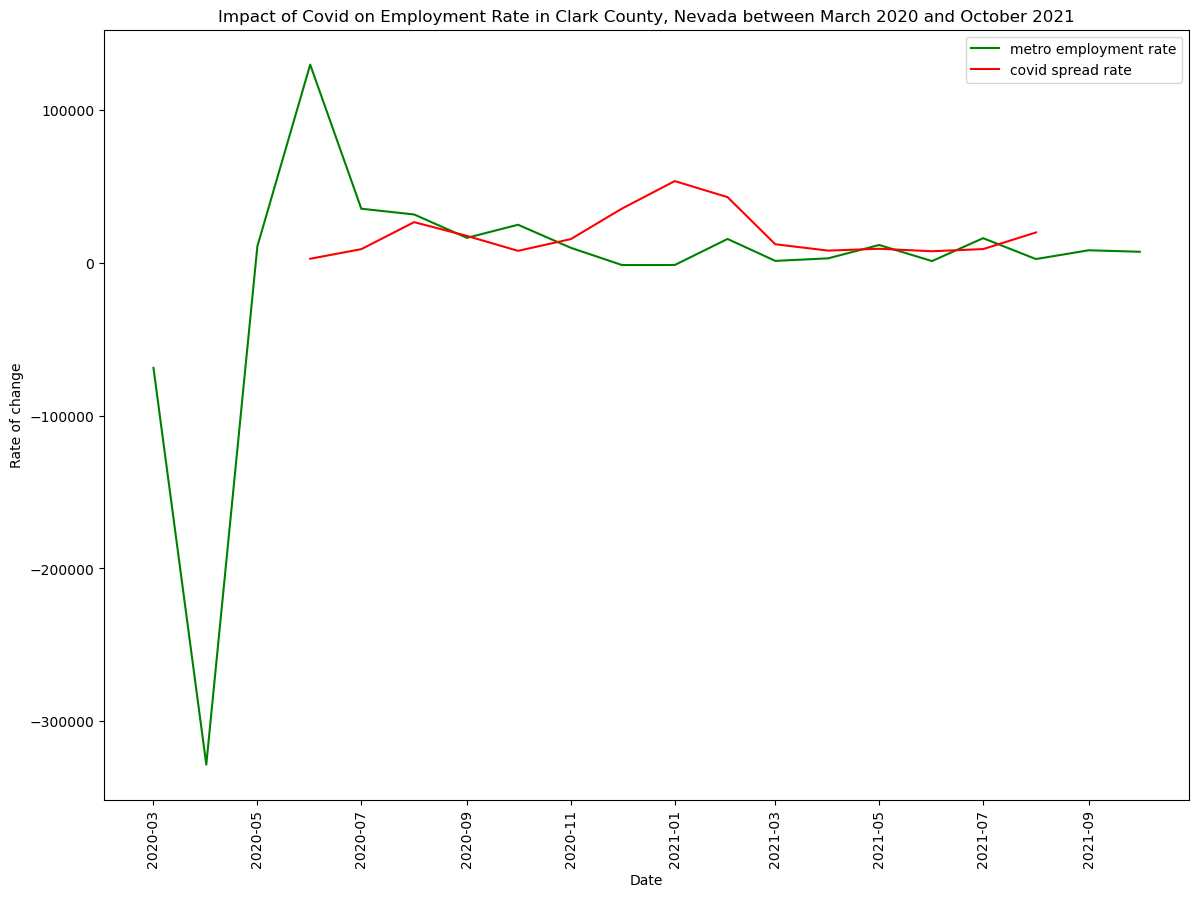

In [345]:
visualize_timeseries(unemployment_covid_df, 
                     title='Impact of Covid on Employment Rate in Clark County, Nevada between March 2020 and October 2021',
                     cols=['metro_slope', 'covid_slope'], 
                     label_names=['metro employment rate', 'covid spread rate'], 
                     colors=['green', 'red'], 
                     figsize=(14,10))

<Figure size 640x480 with 0 Axes>

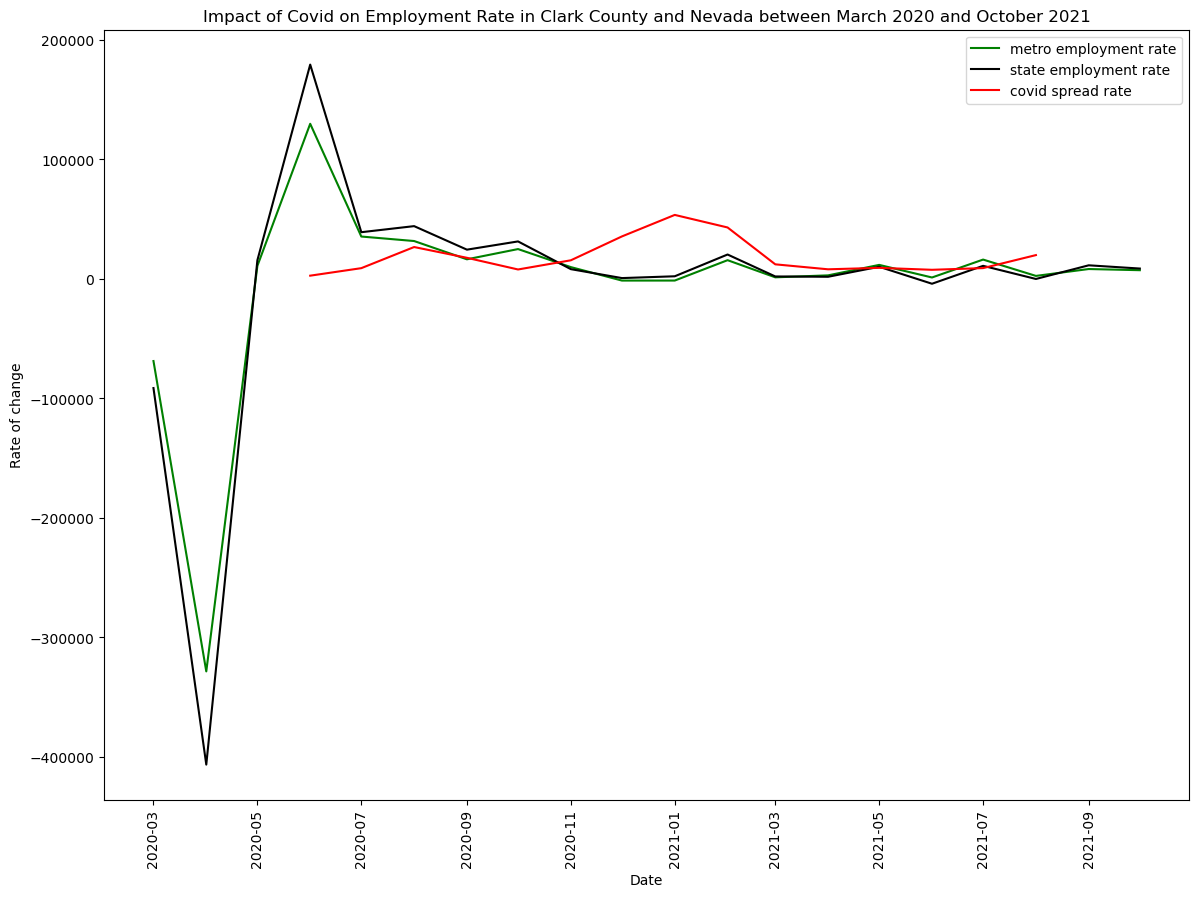

In [346]:
visualize_timeseries(unemployment_covid_df, 
                     title='Impact of Covid on Employment Rate in Clark County and Nevada between March 2020 and October 2021',
                     cols=['metro_slope', 'state_slope', 'covid_slope'], 
                     label_names=['metro employment rate', 'state employment rate', 'covid spread rate'], 
                     colors=['green', 'black', 'red'], 
                     figsize=(14,10))

## Hypothesis Testing

> Above we saw that there was a slight negative correlation between the two variables. Here we want to test if at a 0.05 significance level, the unemployment rate is negatively correlated with confirmed cases. The below sets up a hypothesis test on the correlation coefficient to evaluate whether they are negative (alternative hypothesis) or not correlation/positively correlated (null hypothesis). We do another hypothesis test below for metro impact on state.

$$ {H}_0 :   \rho >= 0 $$
$$ {H}_1 :  \rho < 0 $$
$$ \alpha = 0.05 $$
$$ df = 13 $$
$$ t_{df=13, \alpha=0.05} = r_{critical} = -.441 $$


In [347]:
small_df = unemployment_covid_df[unemployment_covid_df['covid_slope'].notnull()][['metro_slope', 'state_slope', 'covid_slope']]
r = calculate_correlation_coefficient(tt['metro_slope'], tt['covid_slope'])
print(f'r-value observed: { round(r,3)}')

r-value observed: -0.359


Since -.359 is not in the critical region that begins at -.441, we fail to reject the null hypothesis. We retain the null hypothesis and conclude that we have no evidence of a negative relationship between the impact of covid and employment rate. 

In [348]:
r, _ = pearsonr(tt['metro_slope'], tt['state_slope'])
print(f'r-value observed: { round(r,3)}')

r-value observed: 0.995


## How much did Clark County impact Nevada

> Using `Proportion of Variance Explained` through a simple linear regression model we can find out how much of the variance we can predict with the residuals. 

In [282]:
print(f"proportion of variance explained:{calculate_proportion_explained(tt['metro_slope'], tt['state_slope'])}")

proportion of variance explained:0.9903079730833135


> We find a proportion variance of 0.99 which indicates that 99% of the variance is explained the a simple linear model predicting the slope of the state given slope of metro. Below we calculate how much of the state employment is impacted by the metro employment on average

In [244]:
np.mean(unemployment_covid_df['metro_employment']/unemployment_covid_df['state_employment'])

0.7178815207864722

# References

https://psychology.illinoisstate.edu/jccutti/psych138/SP15/Labs/lab20.HTML 